In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import missingno

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

import dill
from joblib import dump # Save the best model
%cd C:\Users\user\Desktop\KUL - Mstat\Modern Data Analytics\proj\

C:\Users\user\Desktop\KUL - Mstat\Modern Data Analytics\proj


In [2]:
# import data
mortality = pd.read_csv('mortality_merged.csv')

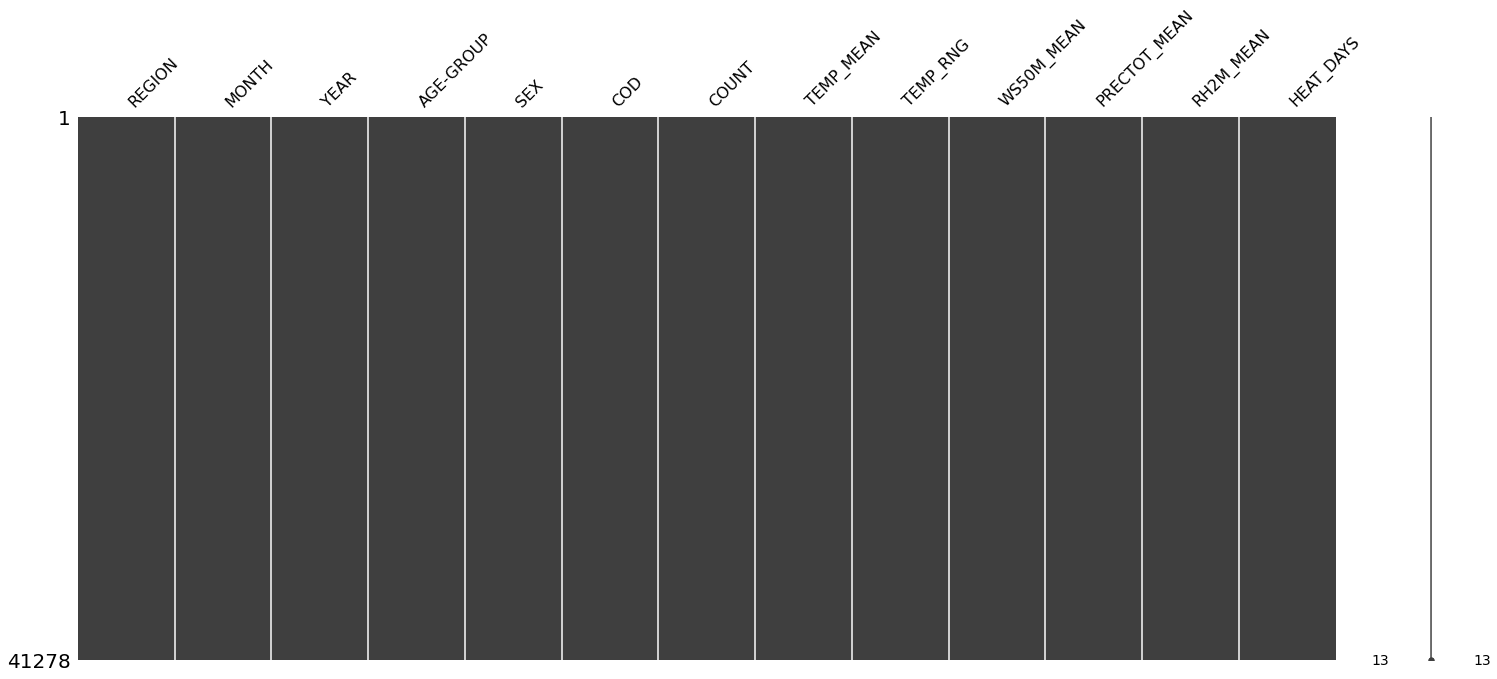

In [3]:
# Check for missing values, it seems alright
missingno.matrix(mortality)

In [4]:
class subset_helper():
    def __init__(self, data):
        self.data = data
        
    def get_summer(self, df):
        return df[(df['MONTH'] <= 8) & (df['MONTH'] >= 5)]

    def get_disease(self, df):
        diseases = ('Diseases of the circulatory system', 
                    'Diseases of the respiratory system', 
                    'Diseases of the skin and subcutaneous tissue')
        return df[df['COD'].isin(diseases)]
    
    def subset(self):
        self.data = self.get_summer(self.data)
        self.data = self.get_disease(self.data)
        return self.data
mortality = subset_helper(mortality).subset()

In [5]:
# Train-test split
TEST_SIZE = 0.2
SEED = 467051528
X_train, X_test, y_train, y_test = train_test_split(mortality.drop('COUNT', axis = 1), 
                                                    mortality['COUNT'], 
                                                    test_size = TEST_SIZE,
                                                    random_state = SEED,
                                                    shuffle = True)

In [6]:
# Preprocessing steps
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(drop = 'first')

categorical_features = ['REGION', 'AGE-GROUP', 'SEX', 'COD']
numeric_features = X_train.columns.to_list()[6:]

preprocessor = ColumnTransformer(
    transformers = [
        ('drop_columns', 'drop', ['YEAR', 'MONTH']),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [7]:
# Parameter grids
learning_rate = np.arange(0.01, 0.2, 0.02)
max_iter = np.arange(100, 1000, 100)
max_leaf_nodes = np.arange(10, 50, 5)
max_depth = np.arange(2, 10, 1)
l2_regularization = np.arange(0, 4, 0.05)

params = {'preprocessing__num' : [StandardScaler(), RobustScaler()], 
         'regressor__loss': ['least_squares', 'least_absolute_deviation', 'poisson'], 
         'regressor__learning_rate': learning_rate, 
         'regressor__max_iter': max_iter,
         'regressor__max_leaf_nodes': max_leaf_nodes,
         'regressor__max_depth': max_depth,
         'regressor__l2_regularization': l2_regularization}

In [8]:
# Model
model = Pipeline(steps = [
    ('preprocessing', preprocessor),
    # ('dense_transform', FunctionTransformer(lambda x: x.todense(), accept_sparse = True)),
    ('regressor', HistGradientBoostingRegressor(categorical_features = np.arange(len(numeric_features), 16)))
])

In [9]:
# Grid search
search = RandomizedSearchCV(model, 
                            param_distributions = params, 
                            random_state = SEED)
search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('drop_columns',
                                                                               'drop',
                                                                               ['YEAR',
                                                                                'MONTH']),
                                                                              ('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['TEMP_MEAN',
                                                                                'TEMP_RNG',
                                                                                'W

In [10]:
# Summary of grid search
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_leaf_nodes,param_regressor__max_iter,param_regressor__max_depth,param_regressor__loss,param_regressor__learning_rate,param_regressor__l2_regularization,param_preprocessing__num,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.924924,0.072610,0.044083,0.022291,45,900,8,least_squares,0.15,1.45,RobustScaler(),"{'regressor__max_leaf_nodes': 45, 'regressor__...",0.978750,0.975119,0.977450,0.975859,0.982184,0.977872,0.002497,4
1,0.523016,0.027924,0.006251,0.007655,25,200,4,least_squares,0.05,3.9,RobustScaler(),"{'regressor__max_leaf_nodes': 25, 'regressor__...",0.925286,0.942751,0.928117,0.922333,0.928051,0.929308,0.007050,8
2,3.720185,0.097261,0.010679,0.006400,40,400,8,least_absolute_deviation,0.15,1.35,RobustScaler(),"{'regressor__max_leaf_nodes': 40, 'regressor__...",0.962581,0.977725,0.979613,0.971324,0.978253,0.973899,0.006340,6
3,1.736954,0.010211,0.015627,0.000001,20,400,8,poisson,0.05,0.65,StandardScaler(),"{'regressor__max_leaf_nodes': 20, 'regressor__...",0.984501,0.981516,0.985523,0.980851,0.988058,0.984090,0.002649,1
4,0.084579,0.000120,0.006251,0.007655,40,100,2,least_squares,0.07,2.45,StandardScaler(),"{'regressor__max_leaf_nodes': 40, 'regressor__...",0.633072,0.673947,0.632650,0.629849,0.614644,0.636833,0.019749,9
5,1.442220,0.082327,0.017175,0.005089,10,600,8,least_squares,0.07,3,StandardScaler(),"{'regressor__max_leaf_nodes': 10, 'regressor__...",0.981248,0.981076,0.981532,0.980373,0.984842,0.981814,0.001561,2
6,0.665540,0.059924,0.012501,0.006251,30,100,9,poisson,0.19,1.05,StandardScaler(),"{'regressor__max_leaf_nodes': 30, 'regressor__...",0.982610,0.972384,0.977599,0.966159,0.984737,0.976698,0.006783,5
7,1.157748,0.062003,0.018530,0.003587,10,800,3,poisson,0.09,0.75,RobustScaler(),"{'regressor__max_leaf_nodes': 10, 'regressor__...",0.979148,0.981578,0.981666,0.980424,0.980720,0.980707,0.000915,3
8,4.499091,0.122847,0.025248,0.007869,20,800,8,least_absolute_deviation,0.05,1.35,RobustScaler(),"{'regressor__max_leaf_nodes': 20, 'regressor__...",0.971579,0.972909,0.977951,0.973117,0.973405,0.973792,0.002172,7
9,0.978712,0.033466,0.017865,0.005080,30,900,2,least_absolute_deviation,0.17,3.55,StandardScaler(),"{'regressor__max_leaf_nodes': 30, 'regressor__...",0.536933,0.612362,0.577762,0.571493,0.545415,0.568793,0.026637,10


In [11]:
# Best fitted scores
print(search.best_params_)
print('Best scores: ', search.best_score_)

{'regressor__max_leaf_nodes': 20, 'regressor__max_iter': 400, 'regressor__max_depth': 8, 'regressor__loss': 'poisson', 'regressor__learning_rate': 0.049999999999999996, 'regressor__l2_regularization': 0.65, 'preprocessing__num': StandardScaler()}
Best scores:  0.9840899005080518


In [12]:
# Test performance
model_chosen = search.best_estimator_
y_pred = model_chosen.predict(X_test)

In [13]:
# Test loss
mean_squared_error(y_pred, y_test)

74.64531510566444

In [14]:
# Training loss
mean_squared_error(y_train, model_chosen.predict(X_train))

20.51470395796455

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


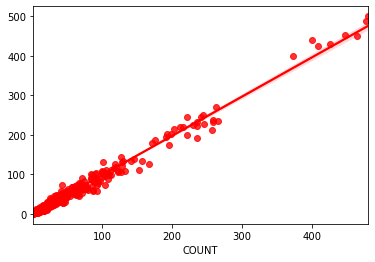

In [15]:
# Test data: y_test, y_pred
sns.regplot(y_test, y_pred, color = 'red')

In [16]:
# R-squared between y_pred and y_test
np.corrcoef(y_test, y_pred)

array([[1.        , 0.99315404],
       [0.99315404, 1.        ]])

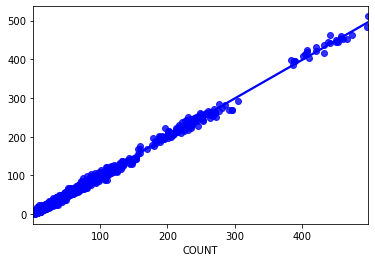

In [17]:
# Training data: y_test, y_pred_train
y_pred_train = model_chosen.predict(X_train)
sns.regplot(x = y_train, y = y_pred_train, color = 'blue')

In [18]:
# R-squared between y_pred and y_pred_train
np.corrcoef(y_train, y_pred_train)

array([[1.        , 0.99815275],
       [0.99815275, 1.        ]])

In [19]:
# Save the model
with open('gradientboosting.pkl', 'wb') as file:
    dill.dump(model_chosen, file) 